## Model Exploration (ML50-2023)

### __Importing libraries__

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint


# Data imports
test = pd.read_csv('Data/test_cleaned.csv', index_col=0)
train = pd.read_csv('Data/train_cleaned.csv', index_col=0)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### __Small processing__

In [301]:
train = train.reset_index(drop=True).drop(columns=['c_patient'])
test = test.reset_index(drop=True).drop(columns=['c_patient'])

In [303]:
cols_payer = [col for col in train.columns if col.startswith('b_payer_')]
train_light = train.drop(columns=cols_payer + ['b_admission_Elective', 'b_admission_Urgent', 'b_admission_nan', 
                                               'b_race_Asian', 'b_race_Hispanic', 'b_race_Other', 'b_race_nan',
                                               'b_source_Referral', 'b_source_Transfer', 'b_source_Unknown', 'b_source_nan',
                                               'b_specialty_group_3', 'b_specialty_group_4', 'b_specialty_group_5', 'b_specialty_group_6',
                                               'b_glu_nan'])

cols_payer_group = [col for col in train.columns if col.startswith('b_payer_group_')]
train_heavy = train.drop(columns=cols_payer_group)

### __Model Testing__

### __Feature Selection__

#### __Using a random forest__
__Modifications:__

<br>

__Relevant Information:__


In [310]:
def get_train_val(data, test_size=0.3, target='b_target', scaler=MinMaxScaler(), sampler='simple', minority_factor=1, verbose=False):
    y = data[target]
    X = data.drop(columns=['b_target', 'c_target'])
    numeric_cols = [col for col in X.columns if col.startswith('n_')]

    if scaler:
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
        
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    if sampler == 'simple': 
        print(f'Simple sampling with minority factor {minority_factor}') if verbose else None
        X_res = pd.concat([X_train, y_train], axis=1)
        minority_class = X_res[X_res[target] == 1]
        majority_class = X_res[X_res[target] == 0]
        # Using the resample function to upsample the minority class
        minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*minority_factor), random_state=42)

        upsampled = pd.concat([majority_class, minority_upsampled])
        X_train = upsampled.drop(columns=target)
        y_train = upsampled[target]

    # Using SMOTE to upsample the minority class, or other IMBLEARN samplers
    elif sampler:
        print('Using {} sampler'.format(sampler)) if verbose else None
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    return X_train, X_val, y_train, y_val

In [311]:
def test_model(model, data, target='b_target', just_score=False, test_size=0.3, sampler='simple', minority_factor=1, verbose=False): 
    X_train, X_test, y_train, y_test = get_train_val(data=data, target=target, test_size=test_size, sampler=sampler, minority_factor=minority_factor, verbose=verbose)
    
    fit = model.fit(X_train, y_train)
    y_pred = fit.predict(X_test)
    if just_score:
        return fit, f1_score(y_test, y_pred)
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    return fit

In [312]:
def perform_random_search(data, model, params_dict, sampler=RandomOverSampler(), scaler=MinMaxScaler(), target='b_target'):
   # Create a pipeline
   pipeline = ImbPipeline([
       ('sampler', sampler),
       ('scaler', scaler),
       ('model', model)
   ])

   y = data[target]
   X = data.drop(columns=['b_target', 'c_target'], errors='ignore')

   # Perform randomized search
   random_search = RandomizedSearchCV(pipeline, params_dict, cv=5, n_jobs=1, random_state=42, verbose=1, scoring='f1')
   random_search.fit(X, y)

   # Print the best parameters
   print("Best parameters: ", random_search.best_params_)

   # Return the best estimator
   return random_search.best_estimator_

In [313]:
def test_model_cv(data, model, params, scaler, sampler='simple', minority_factor=1, target='b_target', cv=4, scoring='f1', verbose=True):
    # Lets program the cv manually so that we can track the progress
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    print(params) if verbose else None
    model = model(**params, random_state=42, n_jobs=-1)
    scores_test, scores_train = [], []
    for i, (train_index, test_index) in enumerate(kf.split(data, data[target])):
        print(f'Starting fold {i+1}/{cv}...') if verbose else None
        X_train, X_test = data.iloc[train_index].copy(), data.iloc[test_index].copy()
        y_train, y_test = data.iloc[train_index][target].copy(), data.iloc[test_index][target].copy()
        X_train = X_train.drop(columns=['b_target', 'c_target'])
        X_test = X_test.drop(columns=['b_target', 'c_target'])

        # Scale the data
        numeric_cols = [col for col in X_train.columns if col.startswith('n_')]
        X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

        # Resample the data
        if sampler == 'simple':
            X_res = pd.concat([X_train, y_train], axis=1)
            minority_class = X_res[X_res[target] == 1]
            majority_class = X_res[X_res[target] == 0]
            # Using the resample function to upsample the minority class
            minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*minority_factor), random_state=42)
            upsampled = pd.concat([majority_class, minority_upsampled])
            X_train = upsampled.drop(columns=target)
            y_train = upsampled[target]
        elif sampler:
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Fit the model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Score
        score_test = f1_score(y_test, y_pred)
        score_train = f1_score(y_train, model.predict(X_train))
        scores_test.append(score_test)
        scores_train.append(score_train)

        print(f'Finished fold {i+1}/{cv}. Score train: {score_train}, score test: {score_test}') if verbose else None
    print(f'Average score: {np.mean(scores_test)} for params: {params}') if verbose else None
    return np.mean(scores_test)

In [314]:
def random_search_manual(data, model, params, scaler, sampler='simple', iter=10, target='b_target', cv=4, scoring='f1', verbose=True):
    # We will use the test_model_cv function to perform the random search
    best_score = 0
    best_params = None

    print(f'Doing {iter} iterations with {cv} folds, totally {iter*cv} fits...') if verbose else None
    for i in range(iter):
        print(f'Iteration {i+1}/{iter}...') if verbose else None
        params_ = {k : np.random.choice(v) for k, v in params.items()}
        score = test_model_cv(data=data, model=model, params=params_, scaler=scaler, sampler=sampler, minority_factor=1, target=target, cv=cv, scoring=scoring, verbose=verbose)
        if score > best_score:
            best_score = score
            best_params = params_
    
    print(f'Best score: {best_score} for params: {best_params}') if verbose else None
    return best_params

#### Logistic Regression

__Relevant Information:__

In [306]:
model = LogisticRegression(max_iter=1000)

test_model(model, train, test_size=0.3)

Accuracy:  0.6652784277023865
Precision:  0.18934063070106855
Recall:  0.609224318658281
F1:  0.2888955164529277
Confusion matrix: 
 [[12764  6221]
 [  932  1453]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.93      0.67      0.78     18985
         1.0       0.19      0.61      0.29      2385

    accuracy                           0.67     21370
   macro avg       0.56      0.64      0.54     21370
weighted avg       0.85      0.67      0.73     21370



LogisticRegression(max_iter=1000)

__Random Forest Classifier__

Best score: 0.2930728334843782 for params: {'n_estimators': 343, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 16, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'entropy', 'class_weight': 'balanced'}


In [316]:
params_dict = {
  'n_estimators': [val for val in range(100, 500)],
  'max_depth': [val for val in range(2s, 25)],
  'min_samples_split': [val for val in range(2,20)],
  'min_samples_leaf': [val for val in range(2,20)],
  'max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
  'bootstrap': [True, False],
  'criterion': ['gini', 'entropy'],
  'class_weight': ['balanced_subsample', 'balanced']
}

best_estimator = random_search_manual(data=train, model=RandomForestClassifier, params=params_dict, scaler=MinMaxScaler(), iter=10, sampler=None)

Doing 10 iterations with 4 folds, totally 40 fits...
Iteration 1/10...
{'n_estimators': 412, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': 0.4, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}
Starting fold 1/4...
Finished fold 1/4. Score train: 0.3687825364189159, score test: 0.28179419525065963
Starting fold 2/4...
Finished fold 2/4. Score train: 0.36152612475732254, score test: 0.29010933129926264
Starting fold 3/4...
Finished fold 3/4. Score train: 0.37102622480816255, score test: 0.2739102969046115
Starting fold 4/4...
Finished fold 4/4. Score train: 0.37549371633752243, score test: 0.28068259385665534
Average score: 0.2816241043277973 for params: {'n_estimators': 412, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': 0.4, 'bootstrap': False, 'criterion': 'gini', 'class_weight': 'balanced'}
Iteration 2/10...
{'n_estimators': 244, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 13, 

In [91]:
# Get the score of the best estimator
best_estimator = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
                       max_depth=14, max_features='sqrt', min_samples_leaf=9,
                       min_samples_split=8, n_estimators=360, n_jobs=-1)

model = RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=16, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=156)

test_model(model, train_light, test_size=0.3)

Accuracy:  0.7737482452035563
Precision:  0.22272521502942508
Recall:  0.4125786163522013
F1:  0.28928413935028663
Confusion matrix: 
 [[15551  3434]
 [ 1401   984]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     18985
         1.0       0.22      0.41      0.29      2385

    accuracy                           0.77     21370
   macro avg       0.57      0.62      0.58     21370
weighted avg       0.84      0.77      0.80     21370



RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=16, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=156)

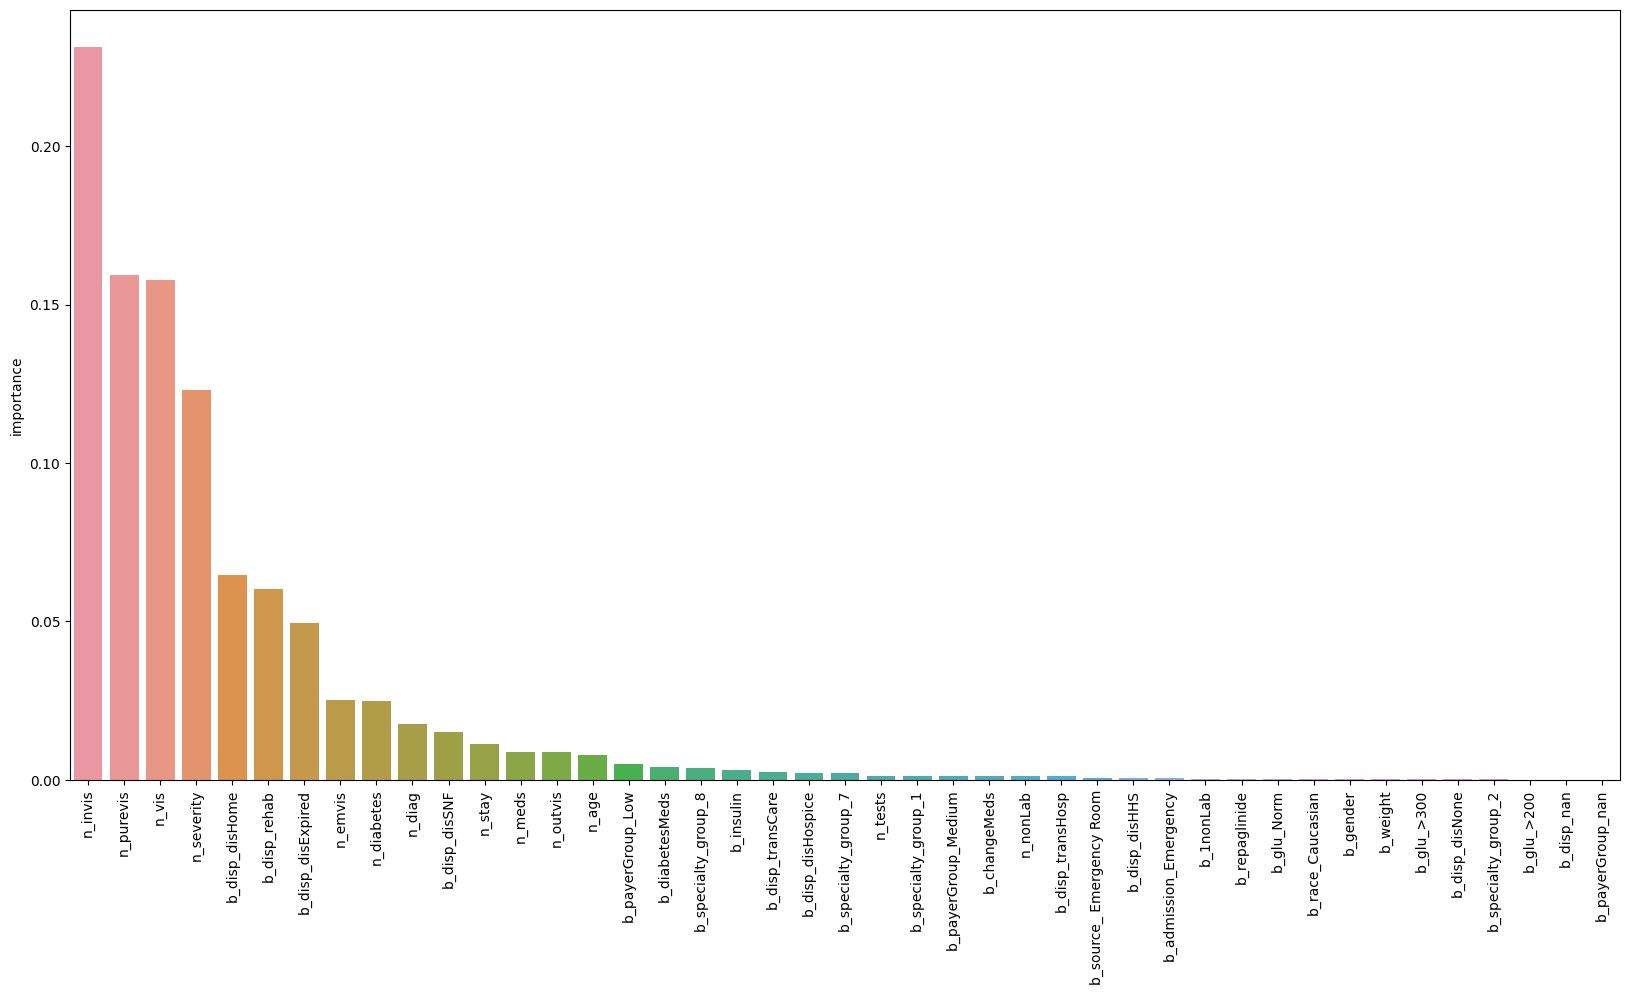

In [58]:
# Fit a random forest classifier
rf_classifier = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample', criterion='gini', max_depth=4, max_features='sqrt', min_samples_leaf=6, min_samples_split=3, n_estimators=420, n_jobs=-1)

X_train, X_val, y_train, y_val = get_train_val(train_light, scaler=MinMaxScaler(), sampler=RandomOverSampler(), test_size=0.3)


rf_classifier.fit(X_train, y_train)

# Get the feature importances
feature_importances = pd.DataFrame(rf_classifier.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(20, 10))
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
plt.xticks(rotation=90)
plt.show()

In [59]:
# Get the f1 score
y_pred = rf_classifier.predict(X_val)
print('F1 score: ', f1_score(y_val, y_pred))

F1 score:  0.2704241948153967
